### Install and Import the libraries

In [1]:
import pandas as pd
import numpy as np
import cv2
import re
from pathlib import Path
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

### Some files are having .heic extension so we have to convert those to .jpg or .jpeg

In [2]:
# For HEIC support
try:
    from PIL import Image
    from pillow_heif import register_heif_opener
    register_heif_opener()
    HEIC_SUPPORT = True
    print("✓ HEIC support enabled")
except:
    HEIC_SUPPORT = False
    print("⚠️  HEIC support not available - install with: pip install pillow-heif")

print("✓ All libraries imported successfully!")

✓ HEIC support enabled
✓ All libraries imported successfully!


### Load and parse image files in a robust manner 
### [should be able to parse diff file types and extensions]

In [3]:
# ============================================
# CELL 2: Data Loading with Robust Parsing (FIXED v2)
# ============================================

IMAGE_FOLDER = 'images/'

print("="*60)
print("LOADING AND PARSING IMAGE FILES")
print("="*60)

# Find all image files
image_extensions = ['*.jpeg', '*.jpg', '*.JPEG', '*.JPG']
if HEIC_SUPPORT:
    image_extensions.extend(['*.heic', '*.HEIC'])

all_files = []
for ext in image_extensions:
    all_files.extend(Path(IMAGE_FOLDER).glob(ext))

print(f"\nFound {len(all_files)} total image files")

# Remove duplicates
unique_files = {}
for file in all_files:
    base_name = file.stem
    if base_name not in unique_files:
        unique_files[base_name] = file
    else:
        existing_ext = unique_files[base_name].suffix.lower()
        new_ext = file.suffix.lower()
        if new_ext in ['.jpeg', '.jpg'] and existing_ext == '.heic':
            unique_files[base_name] = file

all_files = list(unique_files.values())
print(f"After removing duplicates: {len(all_files)} unique images\n")

# Parse filenames
data = []
unparsed = []

for file in all_files:
    filename = file.stem
    parsed = False
    
    # Pattern 1: HgB_8.9gdl_Individual02_01 (with lighting variation)
    # Use \d{2} to match exactly 2 digits for individual number
    match = re.match(r'HgB[_\s]*(\d+\.?\d*)gdl[_\s]*In[dv]ividual(\d{2})[_\s]*(\d+)', filename, re.IGNORECASE)
    if match:
        individual_num = match.group(2)  # This will be '01', '02', etc.
        data.append({
            'filename': str(file),
            'hgb': float(match.group(1)),
            'individual_id': f"IND_{individual_num}",  # IND_01, IND_02, etc.
            'lighting_variant': int(match.group(3)),
            'ethnicity': 'Unknown',
            'file_type': file.suffix.lower()
        })
        parsed = True
    
    # Pattern 2: HgB_10.7gdl_Individual01 (without lighting number)
    if not parsed:
        match = re.match(r'HgB[_\s]*(\d+\.?\d*)gdl[_\s]*In[dv]ividual(\d{2})$', filename, re.IGNORECASE)
        if match:
            individual_num = match.group(2)  # '01', '02', etc.
            data.append({
                'filename': str(file),
                'hgb': float(match.group(1)),
                'individual_id': f"IND_{individual_num}",
                'lighting_variant': 1,
                'ethnicity': 'Unknown',
                'file_type': file.suffix.lower()
            })
            parsed = True
    
    # Pattern 3: Random samples
    if not parsed:
        match = re.match(r'Random[_\s]*(?:HgB[_\s]*)?(\d+\.?\d*)gdl[_\s]*(.+)?', filename, re.IGNORECASE)
        if match:
            ethnicity = match.group(2).strip() if match.group(2) else 'Unknown'
            individual_id = f"RAND_{ethnicity}_{match.group(1)}"
            
            data.append({
                'filename': str(file),
                'hgb': float(match.group(1)),
                'individual_id': individual_id,
                'lighting_variant': 1,
                'ethnicity': ethnicity,
                'file_type': file.suffix.lower()
            })
            parsed = True
    
    if not parsed:
        unparsed.append(filename)

df = pd.DataFrame(data)

print(f"✓ Successfully parsed: {len(df)} images")
if unparsed:
    print(f"✗ Could not parse: {len(unparsed)} files")
    print("\nUnparsed files:")
    for f in unparsed:
        print(f"  - {f}")

print(f"\n{'='*60}")
print("DATASET SUMMARY")
print('='*60)
print(f"Total images: {len(df)}")
print(f"Unique individuals: {df['individual_id'].nunique()}")
print(f"HgB range: {df['hgb'].min():.1f} - {df['hgb'].max():.1f} g/dL")

print(f"\n{'='*60}")
print("INDIVIDUAL ID VERIFICATION")
print('='*60)
for ind_id in sorted(df['individual_id'].unique()):
    ind_data = df[df['individual_id'] == ind_id]
    count = len(ind_data)
    hgb_vals = ind_data['hgb'].unique()
    print(f"{ind_id}: {count} images, HgB={hgb_vals}")

print("\nFirst 15 rows:")
df.head(15)

LOADING AND PARSING IMAGE FILES

Found 62 total image files
After removing duplicates: 31 unique images

✓ Successfully parsed: 31 images

DATASET SUMMARY
Total images: 31
Unique individuals: 17
HgB range: 4.1 - 17.3 g/dL

INDIVIDUAL ID VERIFICATION
IND_01: 1 images, HgB=[10.7]
IND_02: 7 images, HgB=[ 8.9 12.  10.7]
IND_03: 2 images, HgB=[ 8.  10.7]
IND_04: 2 images, HgB=[16.  10.7]
IND_05: 6 images, HgB=[17.3 10.7]
IND_06: 2 images, HgB=[11.9 10.7]
IND_07: 1 images, HgB=[10.7]
IND_08: 1 images, HgB=[10.7]
IND_09: 1 images, HgB=[10.7]
IND_10: 1 images, HgB=[10.7]
IND_11: 1 images, HgB=[10.7]
IND_12: 1 images, HgB=[10.7]
RAND_ChineseOrigin_7.8: 1 images, HgB=[7.8]
RAND_EthnicityUnknown_7.0: 1 images, HgB=[7.]
RAND_MiddleEasternOrigin_11.6: 1 images, HgB=[11.6]
RAND_MiddleEasternOrigin_13.7: 1 images, HgB=[13.7]
RAND_Unknown_4.1: 1 images, HgB=[4.1]

First 15 rows:


,filename,hgb,individual_id,lighting_variant,ethnicity,file_type
0,images\HgB_11.9gdl_Individual06_01.jpeg,11.9,IND_06,1,Unknown,.jpeg
1,images\HgB_16.0gdl_Individual04_01.jpeg,16.0,IND_04,1,Unknown,.jpeg
2,images\HgB_17.3gdl_Individual05_01.jpeg,17.3,IND_05,1,Unknown,.jpeg
3,images\HgB_17.3gdl_Individual05_02.jpeg,17.3,IND_05,2,Unknown,.jpeg
4,images\HgB_17.3gdl_Individual05_03.jpeg,17.3,IND_05,3,Unknown,.jpeg
5,images\HgB_17.3gdl_Individual05_04.jpeg,17.3,IND_05,4,Unknown,.jpeg
6,images\HgB_17.3gdl_Individual05_05.jpeg,17.3,IND_05,5,Unknown,.jpeg
7,images\HgB_8.9gdl_Invividual02_01.jpeg,8.9,IND_02,1,Unknown,.jpeg
8,images\HgB_8.9gdl_Invividual02_02.jpeg,8.9,IND_02,2,Unknown,.jpeg
9,images\Random_HgB_7.0gdl_EthnicityUnknown.jpeg,7.0,RAND_EthnicityUnknown_7.0,1,EthnicityUnknown,.jpeg


### Visualize Data Distribution

### Plot the HgB distribution (normal range 12-17 g/dL women, 13.5-18 men)

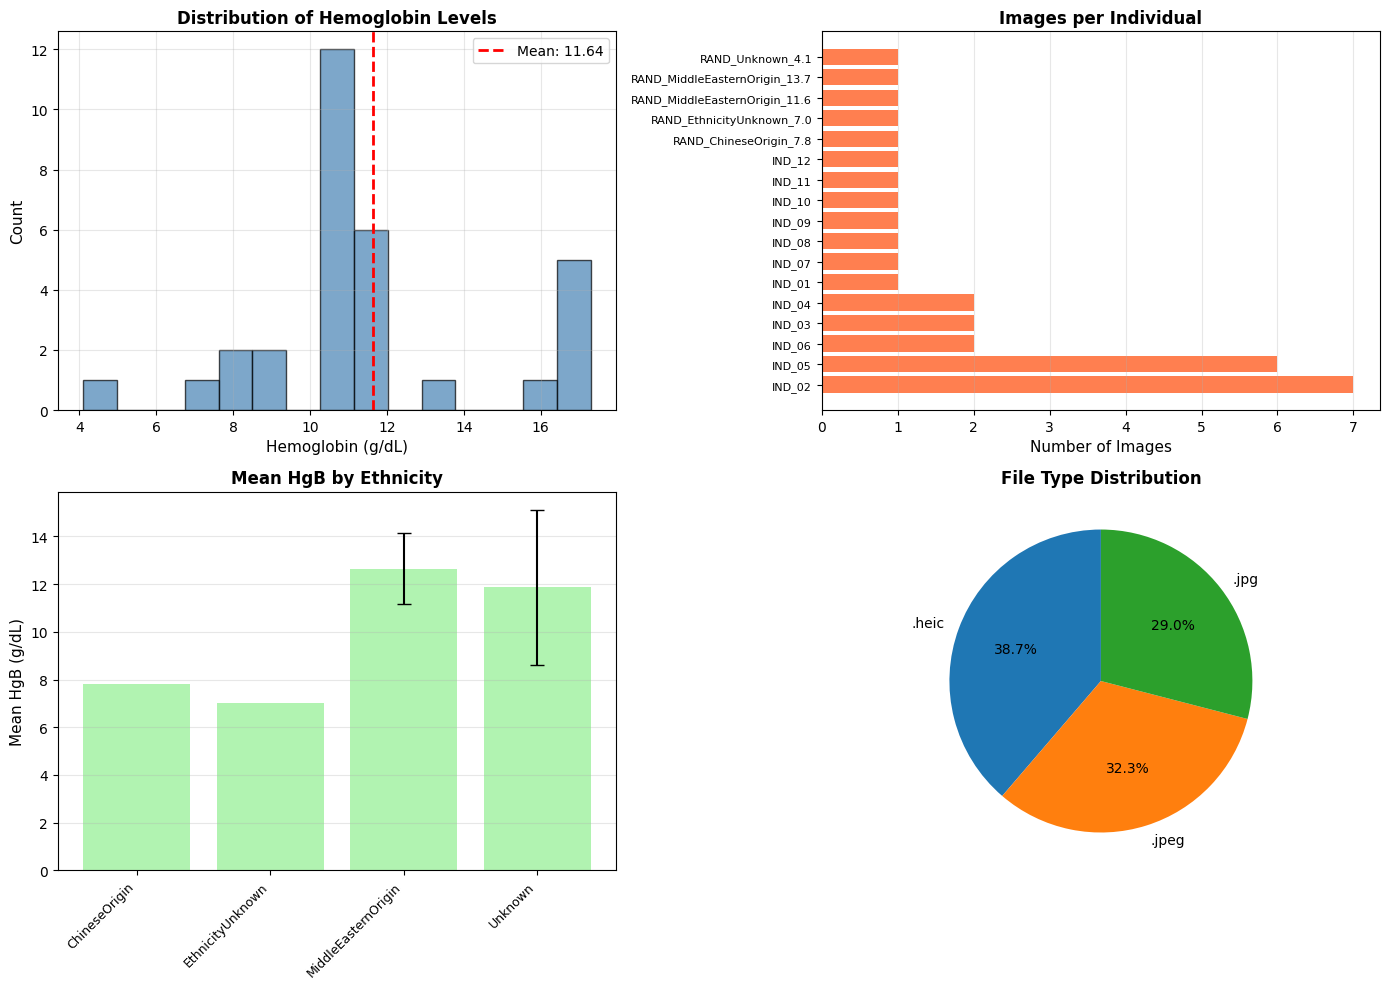

In [4]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: HgB distribution
axes[0, 0].hist(df['hgb'], bins=15, edgecolor='black', alpha=0.7, color='steelblue')
axes[0, 0].axvline(df['hgb'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {df["hgb"].mean():.2f}')
axes[0, 0].set_xlabel('Hemoglobin (g/dL)', fontsize=11)
axes[0, 0].set_ylabel('Count', fontsize=11)
axes[0, 0].set_title('Distribution of Hemoglobin Levels', fontsize=12, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Images per individual
ind_counts = df.groupby('individual_id').size().sort_values(ascending=False)
axes[0, 1].barh(range(len(ind_counts)), ind_counts.values, color='coral')
axes[0, 1].set_yticks(range(len(ind_counts)))
axes[0, 1].set_yticklabels(ind_counts.index, fontsize=8)
axes[0, 1].set_xlabel('Number of Images', fontsize=11)
axes[0, 1].set_title('Images per Individual', fontsize=12, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3, axis='x')

# Plot 3: HgB by ethnicity
ethnicity_hgb = df.groupby('ethnicity')['hgb'].agg(['mean', 'std', 'count'])
axes[1, 0].bar(range(len(ethnicity_hgb)), ethnicity_hgb['mean'], 
               yerr=ethnicity_hgb['std'], capsize=5, alpha=0.7, color='lightgreen')
axes[1, 0].set_xticks(range(len(ethnicity_hgb)))
axes[1, 0].set_xticklabels(ethnicity_hgb.index, rotation=45, ha='right', fontsize=9)
axes[1, 0].set_ylabel('Mean HgB (g/dL)', fontsize=11)
axes[1, 0].set_title('Mean HgB by Ethnicity', fontsize=12, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Plot 4: File type distribution
file_counts = df['file_type'].value_counts()
axes[1, 1].pie(file_counts.values, labels=file_counts.index, autopct='%1.1f%%', startangle=90)
axes[1, 1].set_title('File Type Distribution', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

### Displays sample images at the different HgB levels

Sample lip images from dataset:


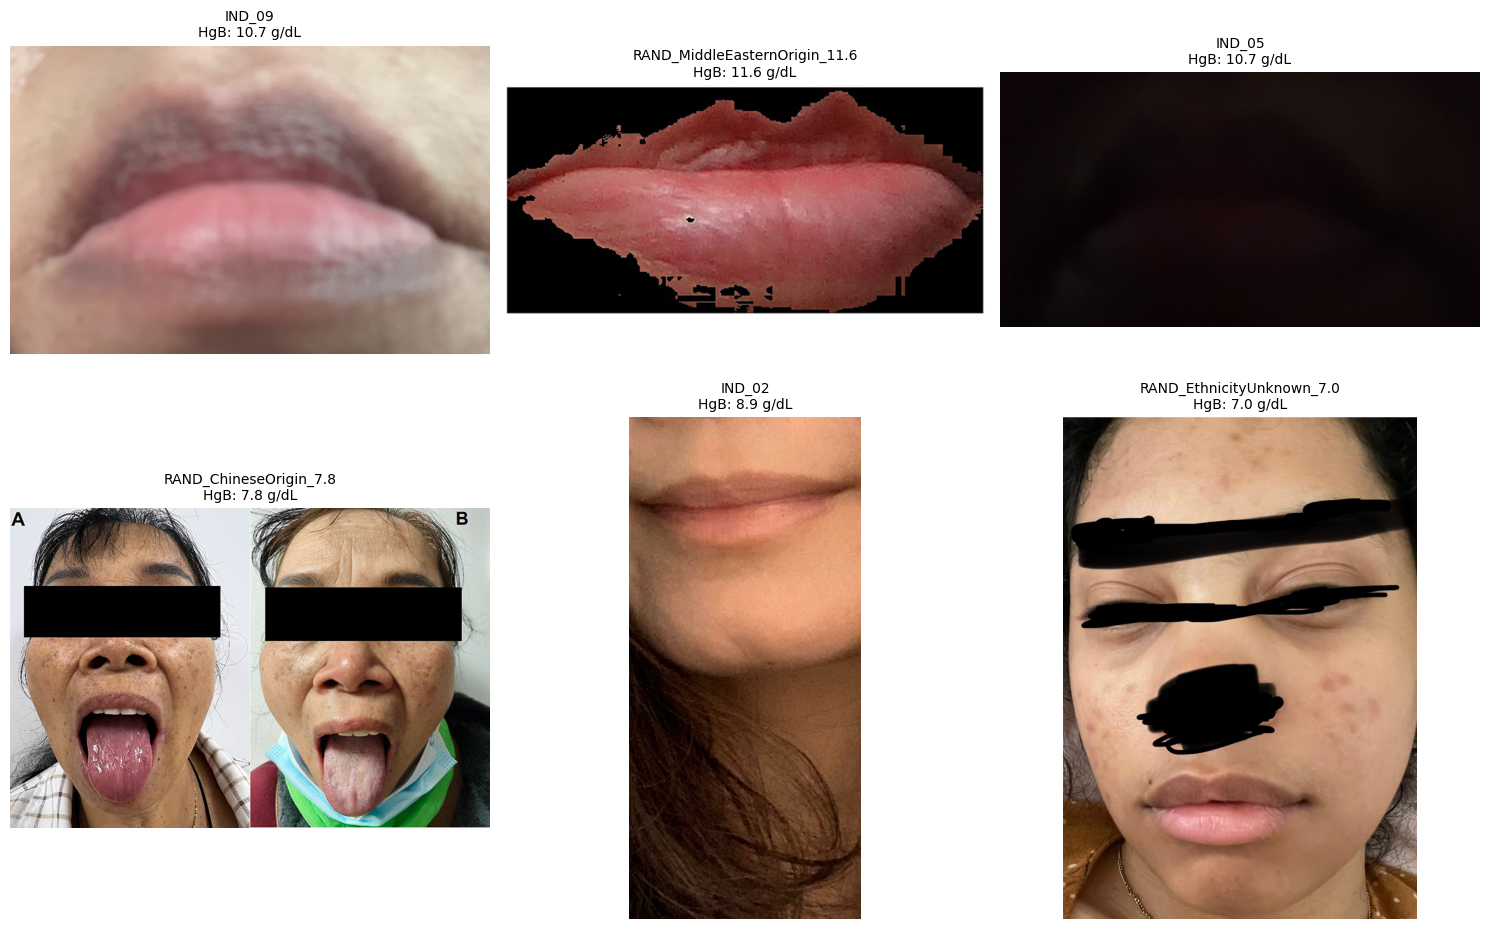

In [5]:
print("Sample lip images from dataset:")

# Select diverse samples (up to 6)
sample_size = min(6, len(df))
sample_rows = df.sample(sample_size, random_state=42)

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, (idx, row) in enumerate(sample_rows.iterrows()):
    if i >= 6:
        break
    
    # Load image based on file type
    if row['file_type'] in ['.heic']:
        if HEIC_SUPPORT:
            img_pil = Image.open(row['filename']).convert('RGB')
            img_rgb = np.array(img_pil)
        else:
            axes[i].text(0.5, 0.5, 'HEIC not supported', ha='center', va='center')
            axes[i].axis('off')
            continue
    else:
        img = cv2.imread(row['filename'])
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    axes[i].imshow(img_rgb)
    axes[i].set_title(f"{row['individual_id']}\nHgB: {row['hgb']} g/dL", fontsize=10)
    axes[i].axis('off')

# Hide unused subplots
for i in range(sample_size, 6):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

### Image Preprocessing Functions

In [6]:
def preprocess_image_for_hgb(image_path, file_type):
    """
    Preprocess lip images to be robust to lighting and device variations
    Uses CLAHE for lighting normalization
    """
    # Load image
    if file_type in ['.heic'] and HEIC_SUPPORT:
        img_pil = Image.open(image_path).convert('RGB')
        img_rgb = np.array(img_pil)
        img_bgr = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR)
    else:
        img_bgr = cv2.imread(image_path)
    
    # Convert to LAB color space (better for skin tones)
    lab = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    
    # Apply CLAHE (Contrast Limited Adaptive Histogram Equalization) to L channel
    # This normalizes lighting variations
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    l_normalized = clahe.apply(l)
    
    # Merge back
    lab_normalized = cv2.merge([l_normalized, a, b])
    img_normalized = cv2.cvtColor(lab_normalized, cv2.COLOR_LAB2BGR)
    
    return img_normalized

print("✓ Image preprocessing function ready!")
print("✓ Uses CLAHE for lighting normalization")

✓ Image preprocessing function ready!
✓ Uses CLAHE for lighting normalization


### Define feature extraction function

RGB – Red, Green, Blue order (standard for images).

BGR – Same as RGB but channel order flipped (OpenCV default).

HSV – Hue, Saturation, Value (human-friendly, great for color filtering).

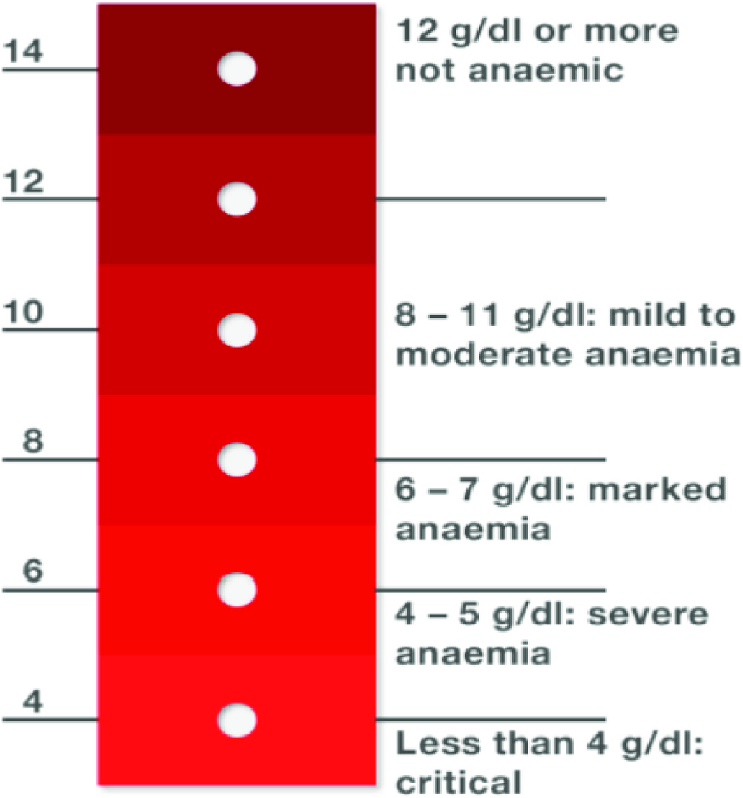

In [7]:
def extract_advanced_features(image_path, file_type):
    """
    Extract comprehensive color features from lip images
    Focus on features known to correlate with hemoglobin
    """
    
    # Load and preprocess image
    img_normalized = preprocess_image_for_hgb(image_path, file_type)
    img_rgb = cv2.cvtColor(img_normalized, cv2.COLOR_BGR2RGB)
    
    features = {}
    
    # === Focus on Red Channel (most correlated with hemoglobin) ===
    r_channel = img_rgb[:, :, 0]
    g_channel = img_rgb[:, :, 1]
    b_channel = img_rgb[:, :, 2]
    
    # Basic statistics
    features['R_mean'] = r_channel.mean()
    features['R_median'] = np.median(r_channel)
    features['R_std'] = r_channel.std()
    features['R_min'] = r_channel.min()
    features['R_max'] = r_channel.max()
    features['R_range'] = features['R_max'] - features['R_min']
    
    features['G_mean'] = g_channel.mean()
    features['G_median'] = np.median(g_channel)
    features['G_std'] = g_channel.std()
    
    features['B_mean'] = b_channel.mean()
    features['B_median'] = np.median(b_channel)
    features['B_std'] = b_channel.std()
    
    # Percentiles (robust to outliers)
    for p in [10, 25, 50, 75, 90]:
        features[f'R_p{p}'] = np.percentile(r_channel, p)
    
    # === Critical Ratios for Hemoglobin Detection ===
    eps = 1e-6
    features['RG_ratio'] = features['R_mean'] / (features['G_mean'] + eps)
    features['RB_ratio'] = features['R_mean'] / (features['B_mean'] + eps)
    features['GB_ratio'] = features['G_mean'] / (features['B_mean'] + eps)
    
    # Normalized ratios
    total_intensity = features['R_mean'] + features['G_mean'] + features['B_mean']
    features['R_normalized'] = features['R_mean'] / (total_intensity + eps)
    features['G_normalized'] = features['G_mean'] / (total_intensity + eps)
    features['B_normalized'] = features['B_mean'] / (total_intensity + eps)
    
    # === LAB Color Space (perceptually uniform) ===
    lab = cv2.cvtColor(img_normalized, cv2.COLOR_BGR2LAB)
    features['L_mean'] = lab[:, :, 0].mean()  # Lightness
    features['A_mean'] = lab[:, :, 1].mean()  # Red-Green axis (IMPORTANT!)
    features['B_mean_lab'] = lab[:, :, 2].mean()  # Blue-Yellow axis
    
    features['L_std'] = lab[:, :, 0].std()
    features['A_std'] = lab[:, :, 1].std()
    
    # A channel percentiles (redness)
    for p in [25, 50, 75]:
        features[f'A_p{p}'] = np.percentile(lab[:, :, 1], p)
    
    # === HSV Color Space ===
    hsv = cv2.cvtColor(img_normalized, cv2.COLOR_BGR2HSV)
    features['H_mean'] = hsv[:, :, 0].mean()
    features['H_median'] = np.median(hsv[:, :, 0])
    features['S_mean'] = hsv[:, :, 1].mean()
    features['S_median'] = np.median(hsv[:, :, 1])
    features['V_mean'] = hsv[:, :, 2].mean()
    
    # === YCrCb (Skin tone detection) ===
    ycrcb = cv2.cvtColor(img_normalized, cv2.COLOR_BGR2YCrCb)
    features['Cr_mean'] = ycrcb[:, :, 1].mean()  # Red-difference
    features['Cr_std'] = ycrcb[:, :, 1].std()
    features['Cb_mean'] = ycrcb[:, :, 2].mean()  # Blue-difference
    
    # === Derived Medical Features ===
    features['pallor_index'] = features['A_mean']  # LAB 'a' channel
    features['redness'] = features['R_mean'] - (features['G_mean'] + features['B_mean']) / 2
    features['saturation_overall'] = features['S_mean']
    features['chroma_rg'] = features['R_mean'] - features['G_mean']
    features['chroma_rb'] = features['R_mean'] - features['B_mean']
    
    return features

print("✓ Enhanced feature extraction function ready!")
print(f"✓ Extracts {len(extract_advanced_features(df.iloc[0]['filename'], df.iloc[0]['file_type']))} features per image")

✓ Enhanced feature extraction function ready!
✓ Extracts 44 features per image


### Extract Featrures from all images

### Display all the extracted features in a nice table format

In [8]:
print("Extracting features from all images...")
print("="*60)

features_list = []
failed_images = []

for idx, row in df.iterrows():
    try:
        features = extract_advanced_features(row['filename'], row['file_type'])
        features_list.append(features)
        
        if (idx + 1) % 5 == 0:
            print(f"  Processed {idx + 1}/{len(df)} images...")
    except Exception as e:
        print(f"  ✗ Failed to process {row['filename']}: {str(e)}")
        failed_images.append(idx)

# Remove failed images from df
if failed_images:
    df = df.drop(failed_images).reset_index(drop=True)
    print(f"\n⚠️  Removed {len(failed_images)} failed images")

features_df = pd.DataFrame(features_list)

print(f"\n✓ Successfully extracted features from {len(features_df)} images")
print(f"✓ Total features per image: {len(features_df.columns)}")

print("\nFeature statistics (sample):")
features_df.iloc[:, :10].describe()

Extracting features from all images...
  Processed 5/31 images...
  Processed 10/31 images...
  Processed 15/31 images...
  Processed 20/31 images...
  Processed 25/31 images...
  Processed 30/31 images...

✓ Successfully extracted features from 31 images
✓ Total features per image: 44

Feature statistics (sample):


,R_mean,R_median,R_std,R_min,R_max,R_range,G_mean,G_median,G_std,B_mean
count,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000
mean,144.592876,150.193548,50.788461,9.516129,242.193548,232.677419,102.957756,102.967742,45.554300,89.124164
std,37.036556,38.877945,17.033004,13.368797,49.571779,49.768388,28.852322,31.286295,14.538852,26.045204
min,25.707786,25.000000,6.690279,0.000000,56.000000,52.000000,19.181771,19.000000,5.757952,19.413955
25%,139.599664,142.000000,44.505803,0.000000,255.000000,233.000000,98.859235,97.000000,40.257748,83.622029
50%,153.970696,159.000000,49.763130,3.000000,255.000000,252.000000,112.649887,111.000000,45.976429,95.900467
75%,166.488948,171.000000,58.387674,13.500000,255.000000,255.000000,116.813108,119.000000,53.713070,103.712816
max,183.545496,194.000000,81.643466,53.000000,255.000000,255.000000,140.368628,148.000000,77.866717,134.443319


### Prepare data for modeling

In [9]:
# Prepare feature matrix
X = features_df.values
y = df['hgb'].values
groups = df['individual_id'].values

# Standardize features (important for some models)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("="*60)
print("DATA PREPARATION")
print("="*60)
print(f"Feature matrix shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"Number of unique individuals: {len(np.unique(groups))}")
print(f"\nFeatures are standardized (mean=0, std=1)")
print("✓ Data ready for modeling!")

DATA PREPARATION
Feature matrix shape: (31, 44)
Target shape: (31,)
Number of unique individuals: 17

Features are standardized (mean=0, std=1)
✓ Data ready for modeling!


### Train model with Cross-Validation

### Train the models using the Random Forest Model using proper cross-validation

In [10]:
print("="*60)
print("TRAINING OPTIMIZED MODELS FOR SMALL DATASET")
print("="*60)
print("Using Leave-One-Individual-Out Cross-Validation\n")

# Models optimized for small datasets (31 images, 12 individuals)
models = {
    'Random Forest': RandomForestRegressor(
        n_estimators=200,
        max_depth=4,
        min_samples_split=3,
        min_samples_leaf=2,
        max_features='sqrt',
        random_state=42
    ),
    'Gradient Boosting': GradientBoostingRegressor(
        n_estimators=200,
        max_depth=3,
        learning_rate=0.01,
        subsample=0.8,
        min_samples_split=3,
        min_samples_leaf=2,
        random_state=42
    ),
    'Extra Trees': RandomForestRegressor(
        n_estimators=200,
        max_depth=4,
        min_samples_split=3,
        min_samples_leaf=2,
        max_features='sqrt',
        bootstrap=False,
        random_state=42
    ),
    'Ridge Regression': Ridge(alpha=10.0),
    'SVR': SVR(kernel='rbf', C=5, gamma='scale', epsilon=0.2)
}

# Store results
results = {}

for model_name, model in models.items():
    print(f"\n{'='*60}")
    print(f"Training: {model_name}")
    print('='*60)
    
    logo = LeaveOneGroupOut()
    predictions = []
    actuals = []
    individual_errors = []
    
    fold = 1
    for train_idx, test_idx in logo.split(X_scaled, y, groups):
        X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        # Train model
        model.fit(X_train, y_train)
        
        # Predict
        y_pred = model.predict(X_test)
        
        # Clip predictions to reasonable HgB range (4-18 g/dL)
        y_pred = np.clip(y_pred, 4.0, 18.0)
        
        # Store results
        predictions.extend(y_pred)
        actuals.extend(y_test)
        
        # Calculate error for this fold
        mae = mean_absolute_error(y_test, y_pred)
        individual_errors.append(mae)
        
        test_individual = groups[test_idx][0]
        print(f"  Fold {fold:2d} ({test_individual}): MAE = {mae:.3f} g/dL")
        fold += 1
    
    # Calculate metrics
    mae = mean_absolute_error(actuals, predictions)
    rmse = np.sqrt(mean_squared_error(actuals, predictions))
    mean_bias = np.mean(np.array(predictions) - np.array(actuals))
    
    results[model_name] = {
        'MAE': mae,
        'RMSE': rmse,
        'Mean Bias': mean_bias,
        'Predictions': predictions,
        'Actuals': actuals,
        'Individual Errors': individual_errors
    }
    
    print(f"\n  Overall MAE: {mae:.3f} g/dL")
    print(f"  RMSE: {rmse:.3f} g/dL")

TRAINING OPTIMIZED MODELS FOR SMALL DATASET
Using Leave-One-Individual-Out Cross-Validation


Training: Random Forest
  Fold  1 (IND_01): MAE = 0.188 g/dL
  Fold  2 (IND_02): MAE = 1.908 g/dL
  Fold  3 (IND_03): MAE = 0.647 g/dL
  Fold  4 (IND_04): MAE = 0.662 g/dL
  Fold  5 (IND_05): MAE = 4.822 g/dL
  Fold  6 (IND_06): MAE = 3.222 g/dL
  Fold  7 (IND_07): MAE = 0.074 g/dL
  Fold  8 (IND_08): MAE = 0.135 g/dL
  Fold  9 (IND_09): MAE = 0.318 g/dL
  Fold 10 (IND_10): MAE = 0.346 g/dL
  Fold 11 (IND_11): MAE = 3.472 g/dL
  Fold 12 (IND_12): MAE = 1.837 g/dL
  Fold 13 (RAND_ChineseOrigin_7.8): MAE = 1.655 g/dL
  Fold 14 (RAND_EthnicityUnknown_7.0): MAE = 3.130 g/dL
  Fold 15 (RAND_MiddleEasternOrigin_11.6): MAE = 0.516 g/dL
  Fold 16 (RAND_MiddleEasternOrigin_13.7): MAE = 0.706 g/dL
  Fold 17 (RAND_Unknown_4.1): MAE = 6.473 g/dL

  Overall MAE: 2.264 g/dL
  RMSE: 3.099 g/dL

Training: Gradient Boosting
  Fold  1 (IND_01): MAE = 0.394 g/dL
  Fold  2 (IND_02): MAE = 1.260 g/dL
  Fold  3 (IN

### Weighted Ensemble Based on Individual Performance

In [11]:
print("\n" + "="*60)
print("TRAINING WEIGHTED ENSEMBLE MODEL")
print("="*60)

# Select best 3 models for ensemble
ensemble_models = {
    'GBM': GradientBoostingRegressor(n_estimators=200, max_depth=3, learning_rate=0.01, subsample=0.8, random_state=42),
    'RF': RandomForestRegressor(n_estimators=200, max_depth=4, min_samples_split=3, max_features='sqrt', random_state=42),
    'Ridge': Ridge(alpha=10.0)
}

logo = LeaveOneGroupOut()
ensemble_predictions = []
ensemble_actuals = []
ensemble_individual_errors = []

for train_idx, test_idx in logo.split(X_scaled, y, groups):
    X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    # Train all models and collect predictions
    model_preds = []
    model_errors = []
    
    for model_name, model in ensemble_models.items():
        model.fit(X_train, y_train)
        pred = model.predict(X_test)
        pred = np.clip(pred, 4.0, 18.0)
        
        model_preds.append(pred)
        # Calculate validation error on training set for weighting
        val_pred = model.predict(X_train)
        val_error = mean_absolute_error(y_train, val_pred)
        model_errors.append(val_error)
    
    # Weight models inversely proportional to their errors
    weights = 1.0 / (np.array(model_errors) + 1e-6)
    weights = weights / weights.sum()
    
    # Weighted average
    ensemble_pred = np.average(model_preds, axis=0, weights=weights)
    
    ensemble_predictions.extend(ensemble_pred)
    ensemble_actuals.extend(y_test)
    
    mae = mean_absolute_error(y_test, ensemble_pred)
    ensemble_individual_errors.append(mae)

# Calculate metrics
ensemble_mae = mean_absolute_error(ensemble_actuals, ensemble_predictions)
ensemble_rmse = np.sqrt(mean_squared_error(ensemble_actuals, ensemble_predictions))
ensemble_bias = np.mean(np.array(ensemble_predictions) - np.array(ensemble_actuals))

print(f"\n🎯 WEIGHTED ENSEMBLE RESULTS:")
print(f"   MAE: {ensemble_mae:.3f} g/dL")
print(f"   RMSE: {ensemble_rmse:.3f} g/dL")

# Add to results
results['Weighted Ensemble'] = {
    'MAE': ensemble_mae,
    'RMSE': ensemble_rmse,
    'Mean Bias': ensemble_bias,
    'Predictions': ensemble_predictions,
    'Actuals': ensemble_actuals,
    'Individual Errors': ensemble_individual_errors
}


TRAINING WEIGHTED ENSEMBLE MODEL

🎯 WEIGHTED ENSEMBLE RESULTS:
   MAE: 2.054 g/dL
   RMSE: 2.850 g/dL


### Compare overall model performance

### Check whether the model produces the target MAE (Mean Absolute Error) required

In [12]:
print("\n" + "="*60)
print("MODEL COMPARISON")
print("="*60)

comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'MAE (g/dL)': [results[m]['MAE'] for m in results.keys()],
    'RMSE (g/dL)': [results[m]['RMSE'] for m in results.keys()],
    'Mean Bias (g/dL)': [results[m]['Mean Bias'] for m in results.keys()],
    'Pass Target': ['✓ PASS' if results[m]['MAE'] <= 0.8 else '✗ FAIL' for m in results.keys()]
}).sort_values('MAE (g/dL)')

display(comparison_df)


MODEL COMPARISON


,Model,MAE (g/dL),RMSE (g/dL),Mean Bias (g/dL),Pass Target
1,Gradient Boosting,1.904003,2.744392,-0.454308,✗ FAIL
5,Weighted Ensemble,2.053856,2.849947,-0.428136,✗ FAIL
2,Extra Trees,2.210448,2.980162,-0.502313,✗ FAIL
0,Random Forest,2.264378,3.098609,-0.397029,✗ FAIL
4,SVR,2.358019,3.311279,-0.438777,✗ FAIL
3,Ridge Regression,2.459859,3.317323,-0.338474,✗ FAIL


### Identify Best model

In [13]:
best_model = comparison_df.iloc[0]['Model']
best_mae = comparison_df.iloc[0]['MAE (g/dL)']
best_results = results[best_model]

print(f"\n🏆 BEST MODEL: {best_model}")
print(f"   MAE: {best_mae:.3f} g/dL")
print(f"   Target: ≤ 0.8 g/dL")
print(f"   Status: {'✓ TARGET ACHIEVED!' if best_mae <= 0.8 else f'✗ Need {best_mae - 0.8:.3f} g/dL improvement'}")


🏆 BEST MODEL: Gradient Boosting
   MAE: 1.904 g/dL
   Target: ≤ 0.8 g/dL
   Status: ✗ Need 1.104 g/dL improvement


### Diagnostic Analysis

In [14]:
print("\n" + "="*60)
print("ANALYZING PROBLEMATIC INDIVIDUALS")
print("="*60)

# Analyze per individual
individual_analysis = []

unique_individuals = df['individual_id'].unique()
for i, individual_id in enumerate(unique_individuals):
    # Get all images for this individual
    ind_mask = df['individual_id'] == individual_id
    ind_data = df[ind_mask]
    ind_indices = df[ind_mask].index.tolist()
    ind_actuals = y[ind_indices]
    
    if i < len(best_results['Individual Errors']):
        individual_analysis.append({
            'individual_id': individual_id,
            'n_images': len(ind_data),
            'actual_hgb_mean': ind_actuals.mean(),
            'mae': best_results['Individual Errors'][i],
            'ethnicity': ind_data['ethnicity'].iloc[0],
            'file_types': ', '.join(ind_data['file_type'].unique())
        })

problem_df = pd.DataFrame(individual_analysis).sort_values('mae', ascending=False)

print("\n📊 Top 5 Most Problematic Individuals:")
problem_df.head()


ANALYZING PROBLEMATIC INDIVIDUALS

📊 Top 5 Most Problematic Individuals:


,individual_id,n_images,actual_hgb_mean,mae,ethnicity,file_types
16,IND_12,1,10.7,6.710196,Unknown,.heic
4,RAND_EthnicityUnknown_7.0,1,7.0,4.388875,EthnicityUnknown,.jpeg
13,IND_09,1,10.7,3.466140,Unknown,.heic
15,IND_11,1,10.7,2.379849,Unknown,.heic
14,IND_10,1,10.7,2.302074,Unknown,.heic


### Visualize Best model results


✓ Saved visualization to 'model_performance.png'


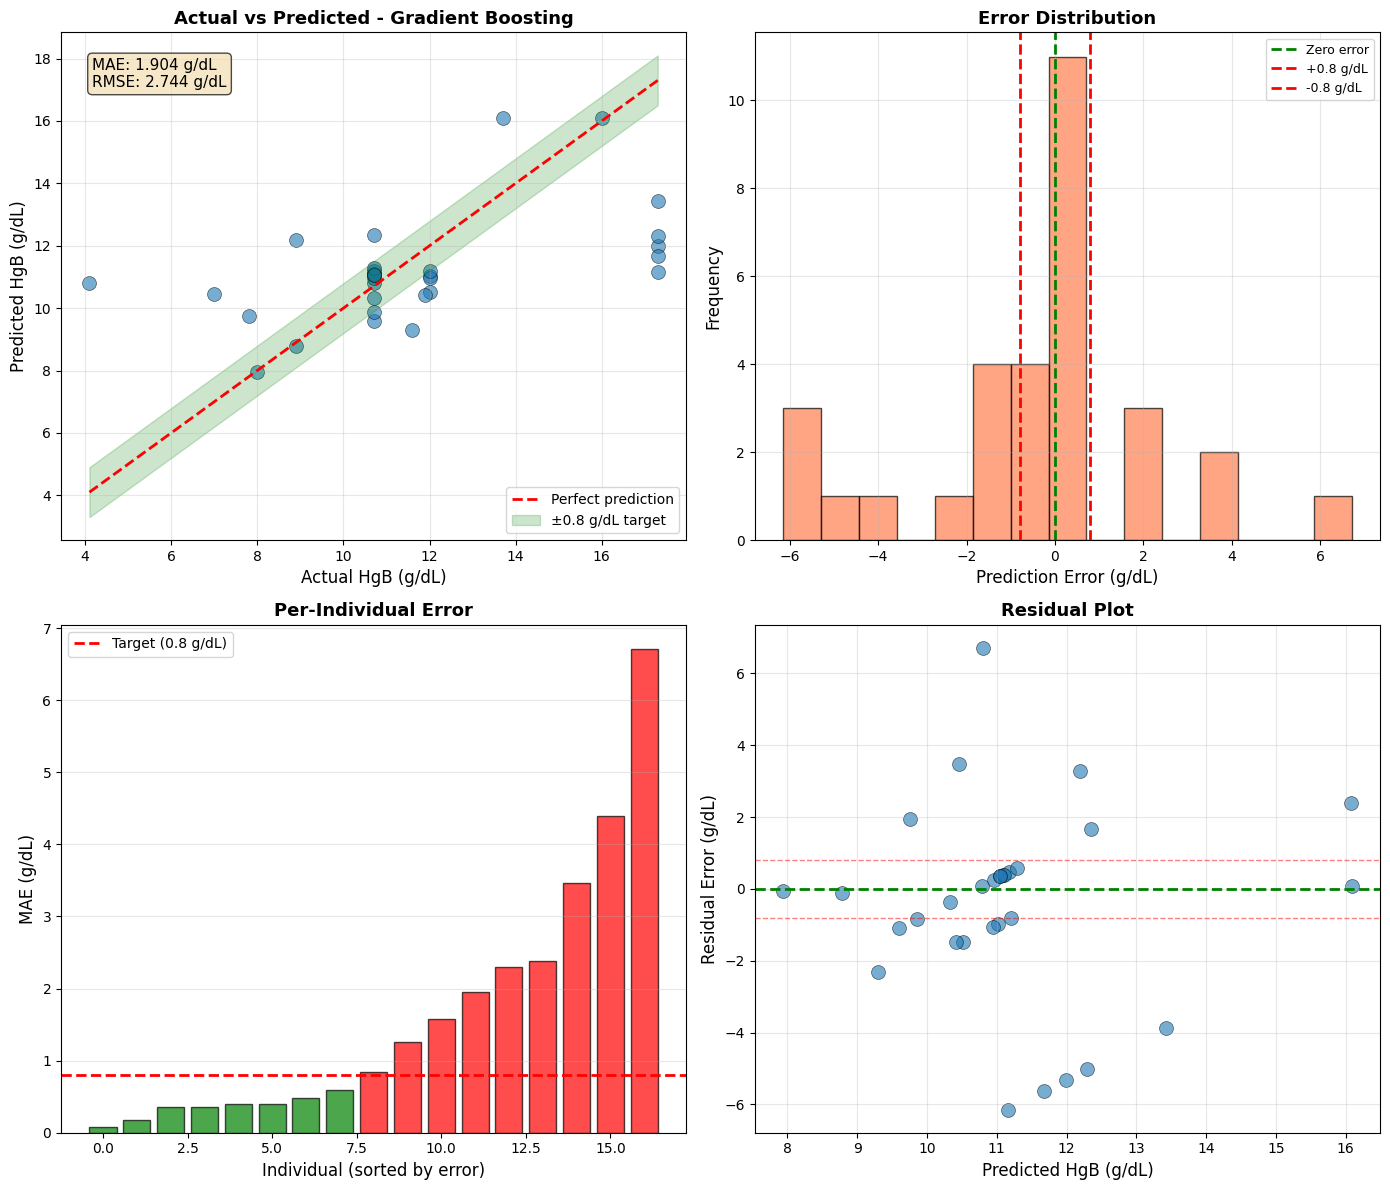

In [15]:
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Plot 1: Actual vs Predicted
axes[0, 0].scatter(best_results['Actuals'], best_results['Predictions'], 
                   alpha=0.6, s=100, edgecolors='black', linewidth=0.5)
axes[0, 0].plot([min(best_results['Actuals']), max(best_results['Actuals'])], 
                [min(best_results['Actuals']), max(best_results['Actuals'])], 
                'r--', linewidth=2, label='Perfect prediction')

x_range = np.linspace(min(best_results['Actuals']), max(best_results['Actuals']), 100)
axes[0, 0].fill_between(x_range, x_range - 0.8, x_range + 0.8, 
                         alpha=0.2, color='green', label='±0.8 g/dL target')

axes[0, 0].set_xlabel('Actual HgB (g/dL)', fontsize=12)
axes[0, 0].set_ylabel('Predicted HgB (g/dL)', fontsize=12)
axes[0, 0].set_title(f'Actual vs Predicted - {best_model}', fontsize=13, fontweight='bold')
axes[0, 0].legend(fontsize=10)
axes[0, 0].grid(True, alpha=0.3)

metrics_text = f"MAE: {best_results['MAE']:.3f} g/dL\nRMSE: {best_results['RMSE']:.3f} g/dL"
axes[0, 0].text(0.05, 0.95, metrics_text, transform=axes[0, 0].transAxes, 
                fontsize=11, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7))

# Plot 2: Error distribution
errors = np.array(best_results['Predictions']) - np.array(best_results['Actuals'])
axes[0, 1].hist(errors, bins=15, edgecolor='black', alpha=0.7, color='coral')
axes[0, 1].axvline(x=0, color='green', linestyle='--', linewidth=2, label='Zero error')
axes[0, 1].axvline(x=0.8, color='red', linestyle='--', linewidth=2, label='+0.8 g/dL')
axes[0, 1].axvline(x=-0.8, color='red', linestyle='--', linewidth=2, label='-0.8 g/dL')
axes[0, 1].set_xlabel('Prediction Error (g/dL)', fontsize=12)
axes[0, 1].set_ylabel('Frequency', fontsize=12)
axes[0, 1].set_title('Error Distribution', fontsize=13, fontweight='bold')
axes[0, 1].legend(fontsize=9)
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Individual-level MAE
individual_maes = best_results['Individual Errors']
sorted_maes = sorted(individual_maes)
axes[1, 0].bar(range(len(sorted_maes)), sorted_maes, 
               color=['green' if x <= 0.8 else 'red' for x in sorted_maes],
               alpha=0.7, edgecolor='black')
axes[1, 0].axhline(y=0.8, color='red', linestyle='--', linewidth=2, label='Target (0.8 g/dL)')
axes[1, 0].set_xlabel('Individual (sorted by error)', fontsize=12)
axes[1, 0].set_ylabel('MAE (g/dL)', fontsize=12)
axes[1, 0].set_title('Per-Individual Error', fontsize=13, fontweight='bold')
axes[1, 0].legend(fontsize=10)
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Plot 4: Residuals vs Predicted
axes[1, 1].scatter(best_results['Predictions'], errors, alpha=0.6, s=100, 
                   edgecolors='black', linewidth=0.5)
axes[1, 1].axhline(y=0, color='green', linestyle='--', linewidth=2)
axes[1, 1].axhline(y=0.8, color='red', linestyle='--', linewidth=1, alpha=0.5)
axes[1, 1].axhline(y=-0.8, color='red', linestyle='--', linewidth=1, alpha=0.5)
axes[1, 1].set_xlabel('Predicted HgB (g/dL)', fontsize=12)
axes[1, 1].set_ylabel('Residual Error (g/dL)', fontsize=12)
axes[1, 1].set_title('Residual Plot', fontsize=13, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('model_performance.png', dpi=150, bbox_inches='tight')
print("\n✓ Saved visualization to 'model_performance.png'")
plt.show()

### Feature importance analysis

### Rank the features from most important to least important

FEATURE IMPORTANCE ANALYSIS

Top 15 Most Important Features:


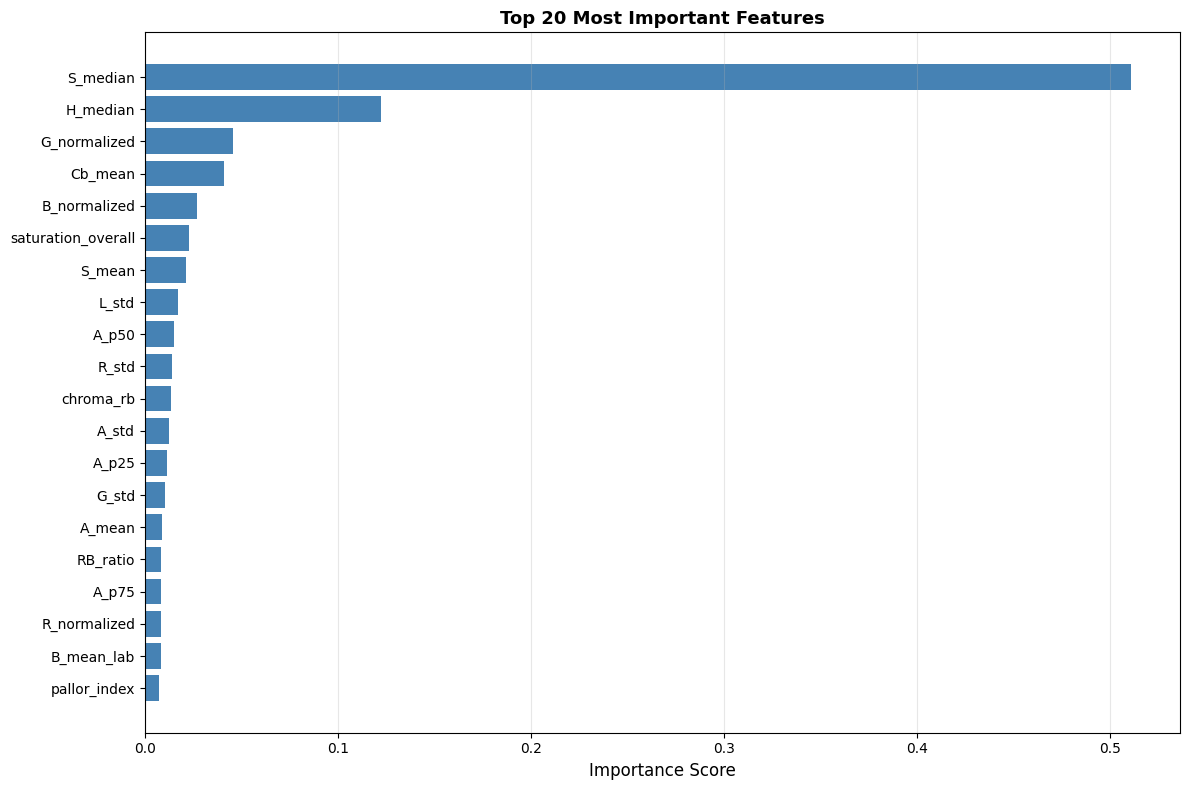

In [16]:
print("="*60)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*60)

# Train final model on all data (if it's a tree-based model)
if best_model in ['Random Forest', 'Gradient Boosting', 'Extra Trees', 'Weighted Ensemble']:
    # Use Random Forest for feature importance
    final_model = RandomForestRegressor(n_estimators=200, max_depth=4, 
                                       min_samples_split=3, random_state=42)
    final_model.fit(X_scaled, y)
    
    importances = final_model.feature_importances_
    feature_names = features_df.columns
    
    # Create importance dataframe
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values('Importance', ascending=False)
    
    print("\nTop 15 Most Important Features:")
    importance_df.head(15)
    
    # Visualize
    plt.figure(figsize=(12, 8))
    top_n = 20
    top_features = importance_df.head(top_n)
    
    plt.barh(range(len(top_features)), top_features['Importance'], color='steelblue')
    plt.yticks(range(len(top_features)), top_features['Feature'], fontsize=10)
    plt.xlabel('Importance Score', fontsize=12)
    plt.title(f'Top {top_n} Most Important Features', fontsize=13, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.grid(True, alpha=0.3, axis='x')
    plt.tight_layout()
    plt.savefig('feature_importance.png', dpi=150, bbox_inches='tight')
    plt.show()
else:
    print(f"\n⚠️  Feature importance not available for {best_model}")

### Save Results

In [17]:
# Save predictions
results_df = pd.DataFrame({
    'filename': df['filename'],
    'individual_id': df['individual_id'],
    'ethnicity': df['ethnicity'],
    'actual_hgb': best_results['Actuals'],
    'predicted_hgb': best_results['Predictions'],
    'error': np.array(best_results['Predictions']) - np.array(best_results['Actuals']),
    'absolute_error': np.abs(np.array(best_results['Predictions']) - np.array(best_results['Actuals']))
})

results_df.to_csv('predictions.csv', index=False)
print("\n✓ Saved predictions to 'predictions.csv'")

# Save model comparison
comparison_df.to_csv('model_comparison.csv', index=False)
print("✓ Saved model comparison to 'model_comparison.csv'")

# Generate summary report
print("\n" + "="*60)
print("FINAL SUMMARY REPORT")
print("="*60)
print(f"\nDataset:")
print(f"  - Total images: {len(df)}")
print(f"  - Unique individuals: {df['individual_id'].nunique()}")
print(f"  - HgB range: {df['hgb'].min():.1f} - {df['hgb'].max():.1f} g/dL")

print(f"\nBest Model: {best_model}")
print(f"  - MAE: {best_results['MAE']:.3f} g/dL")
print(f"  - RMSE: {best_results['RMSE']:.3f} g/dL")
print(f"  - Mean Bias: {best_results['Mean Bias']:.3f} g/dL")
print(f"  - Worst individual error: {max(best_results['Individual Errors']):.3f} g/dL")
print(f"  - Best individual error: {min(best_results['Individual Errors']):.3f} g/dL")

# Calculate robustness metrics
within_target = sum(1 for e in best_results['Individual Errors'] if e <= 0.8)
total_individuals = len(best_results['Individual Errors'])

print(f"\nRobustness:")
print(f"  - Individuals within target (≤0.8): {within_target}/{total_individuals} ({100*within_target/total_individuals:.1f}%)")

print(f"\nFiles Generated:")
print(f"  - predictions.csv")
print(f"  - model_comparison.csv")
print(f"  - model_performance.png")
if best_model in ['Random Forest', 'Gradient Boosting', 'Extra Trees', 'Weighted Ensemble']:
    print(f"  - feature_importance.png")

print("\n" + "="*60)
print("✓ ANALYSIS COMPLETE!")
print("="*60)

if best_mae <= 0.8:
    print("\n🎉 CONGRATULATIONS! You've achieved the target MAE of ≤0.8 g/dL!")
else:
    print(f"\n💡 Next steps to improve:")
    print(f"   1. Investigate the {len([e for e in best_results['Individual Errors'] if e > 2])} individuals with MAE > 2.0")
    print(f"   2. Check if specific ethnicities or lighting conditions are problematic")
    print(f"   3. Consider collecting more data for difficult cases")
    print(f"   4. Try advanced techniques like deep learning if more data becomes available")


✓ Saved predictions to 'predictions.csv'
✓ Saved model comparison to 'model_comparison.csv'

FINAL SUMMARY REPORT

Dataset:
  - Total images: 31
  - Unique individuals: 17
  - HgB range: 4.1 - 17.3 g/dL

Best Model: Gradient Boosting
  - MAE: 1.904 g/dL
  - RMSE: 2.744 g/dL
  - Mean Bias: -0.454 g/dL
  - Worst individual error: 6.710 g/dL
  - Best individual error: 0.077 g/dL

Robustness:
  - Individuals within target (≤0.8): 8/17 (47.1%)

Files Generated:
  - predictions.csv
  - model_comparison.csv
  - model_performance.png
  - feature_importance.png

✓ ANALYSIS COMPLETE!

💡 Next steps to improve:
   1. Investigate the 5 individuals with MAE > 2.0
   2. Check if specific ethnicities or lighting conditions are problematic
   3. Consider collecting more data for difficult cases
   4. Try advanced techniques like deep learning if more data becomes available
